In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mlp

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# dev = 'cpu'
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

In [ ]:
data_path = '/home/z5370003/projects/neurop-l63/data/l63-6.5T/'

In [ ]:
# Data path
mesh_path = os.path.join(data_path, 'mesh.npy')
pdfn_path = os.path.join(data_path, 'post.npy')

# Read numpy matrices
mesh = torch.from_numpy(np.load(mesh_path).reshape((1, 40, 40, 40, 3)))
pdfn = torch.from_numpy(np.load(pdfn_path).reshape((-1, 40, 40, 40, 1)))

pdfn = pdfn[:166]
pdfn = pdfn.repeat((3, 1, 1, 1, 1))

In [ ]:
pdf2d = pdfn.sum(dim=3).squeeze(-1)

# m, n = 3, 3
# ind = np.linspace(0, 198, m*n).astype(int).reshape((m, n))

# fig, ax = plt.subplots(m, n, figsize=(8, 10))

# for i in range(3):
#     for j in range(3):
#         ax[i, j].imshow(pdf2d[ind[i, j]])
#         ax[i, j].set_title(f'{ind[i, j]+1}')


In [ ]:
# pdfflat = pdf2d.view(499, -1)
pdfmin = pdf2d.min() #pdfflat.min(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdfmax = pdf2d.max() # pdfflat.max(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdf2d = ((pdf2d - pdfmin)/(pdfmax - pdfmin))

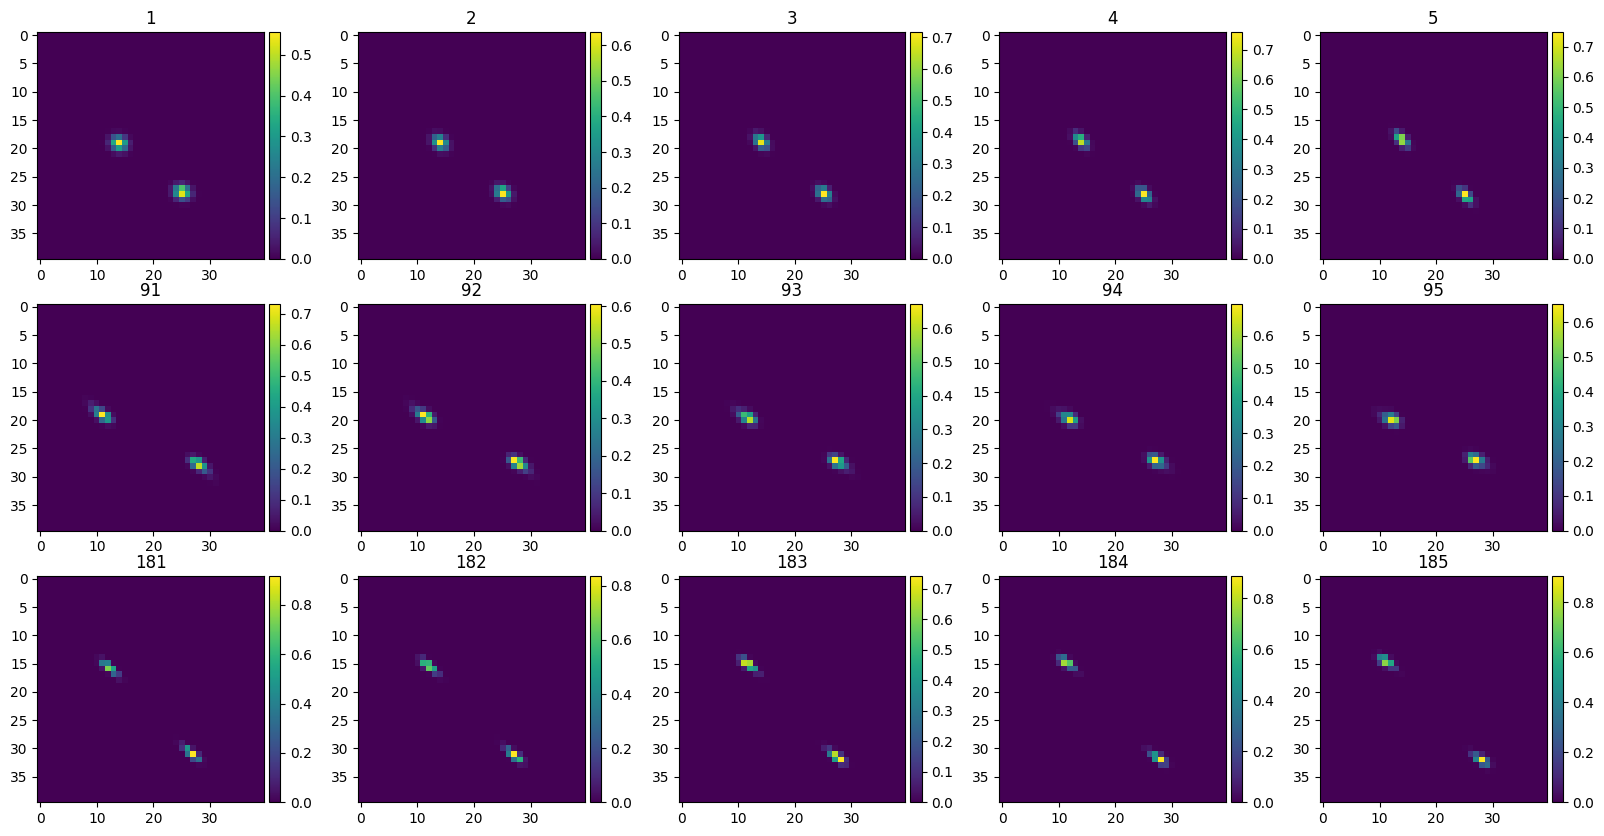

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

m, n = 3, 5
ind = np.linspace(0, 180, m).astype(int)

fig, ax = plt.subplots(m, n, figsize=(20,10))

for i in range(m):
    for j in range(n):
        im = ax[i, j].imshow(pdf2d[ind[i]+j])
        ax[i, j].set_title(f'{ind[i]+j+1}')

        divider = make_axes_locatable(ax[i, j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

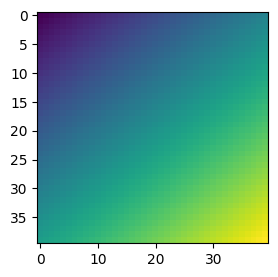

In [ ]:
mesh2d = mesh.mean(-2)[...,:-1]
fig = plt.figure(figsize=(3, 3))
plt.imshow(mesh2d[0].sum(-1))

In [ ]:
p = torch.concat([pdf2d.unsqueeze(-1), mesh2d.repeat(pdf2d.shape[0], 1, 1, 1)],
                 dim=-1)
p = torch.concat([p, p[-2:]], dim=0)
# p = torch.concat([p, ts], dim=-1)
p.shape

torch.Size([500, 40, 40, 3])

In [ ]:
from torch.utils.data import  Dataset
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [ ]:
def get_dataset(p, n_steps=10):
    xs = []
    ys = []
    for i in range(0, p.shape[0]-2*n_steps):
        xs.append(p[i: i+n_steps])
        ys.append(p[i+n_steps:i+2*n_steps, ..., 0].unsqueeze(-1))
    x = torch.stack(xs, dim=0).permute(0, 4, 1, 2, 3)
    y = torch.stack(ys, dim=0).permute(0, 4, 1, 2, 3)
    return DictDataset(x, y)

In [ ]:
full_ds = get_dataset(p, n_steps=10)
train_size = int(0.7 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, 
                                                  [train_size, test_size])


In [ ]:
full_ds[0]['y'].shape

torch.Size([1, 10, 40, 40])

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [ ]:
import sys
from neuralop.models import TFNO, FNO
from neuralop import Trainer
from neuralop.training import OutputEncoderCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [ ]:
model = FNO(n_modes=(6, 16, 16), hidden_channels=32, projection_channels=64, rank=0.42, implementation='reconstructed')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 7093537 parameters.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

l2loss = LpLoss(d=3, p=2)
h1loss = H1Loss(d=3)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [ ]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([32, 32, 6, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv3d(3, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(256, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSE

In [ ]:
trainer = Trainer(model=model, n_epochs=100,
                  device=device,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


In [ ]:
test_dls = {40: test_dl}

In [21]:
trainer.train(train_loader=train_dl,
              test_loaders=test_dls,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

: 

In [71]:
trainer.evaluate(eval_losses, test_dls[40])

{'_h1': 0.059298952420552574, '_l2': 0.05934652934471766}

Text(0.5, 1.0, 'FNO')

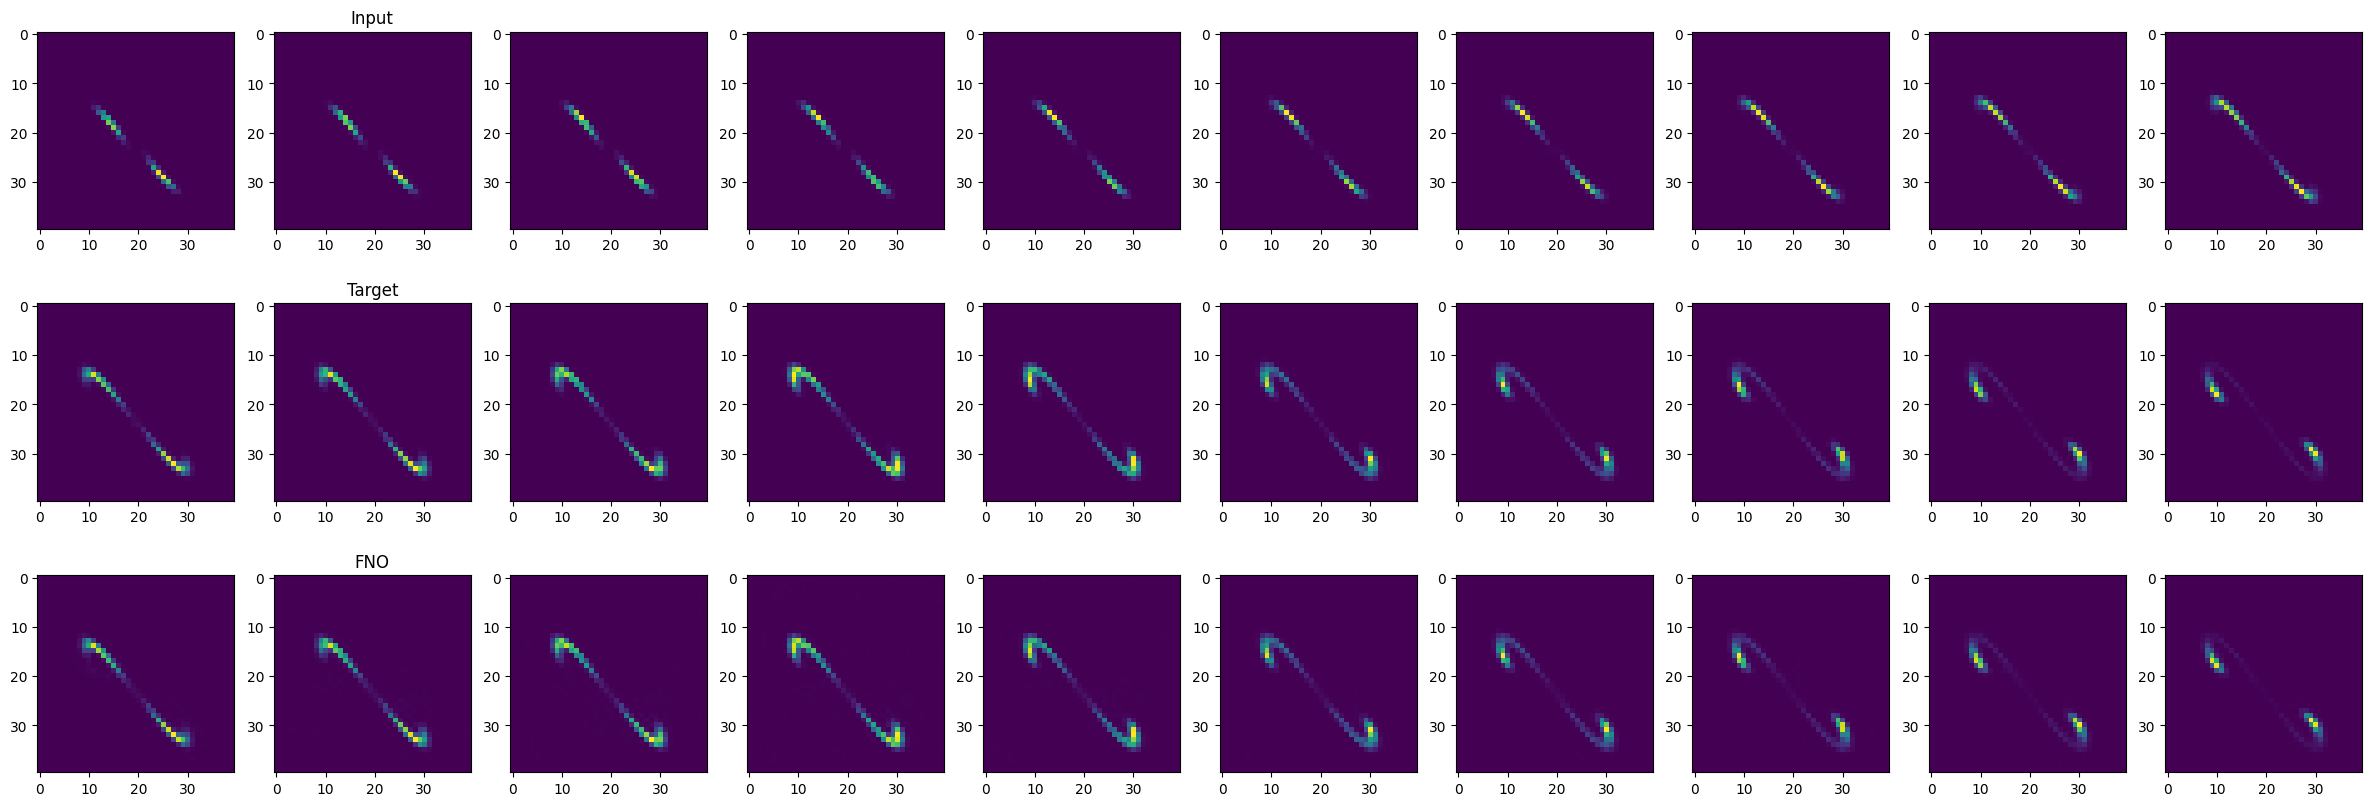

In [72]:
ind = np.random.randint(len(train_ds))

sample = train_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)

fig, ax = plt.subplots(3, a.shape[1], figsize=(a.shape[1]*3,10))


for j in range(a.shape[1]):
    ax[0, j].imshow(a[0, j, ...].cpu())
ax[0, 1].set_title("Input")


for j in range(a.shape[1]):
    ax[1, j].imshow(p[0, j, ...].cpu())
ax[1, 1].set_title("Target")

pred = model(a.unsqueeze(0)).relu()[0].cpu().detach().numpy()

for j in range(a.shape[1]):
    ax[2, j].imshow(pred[0, j, ...])

ax[2, 1].set_title("FNO")

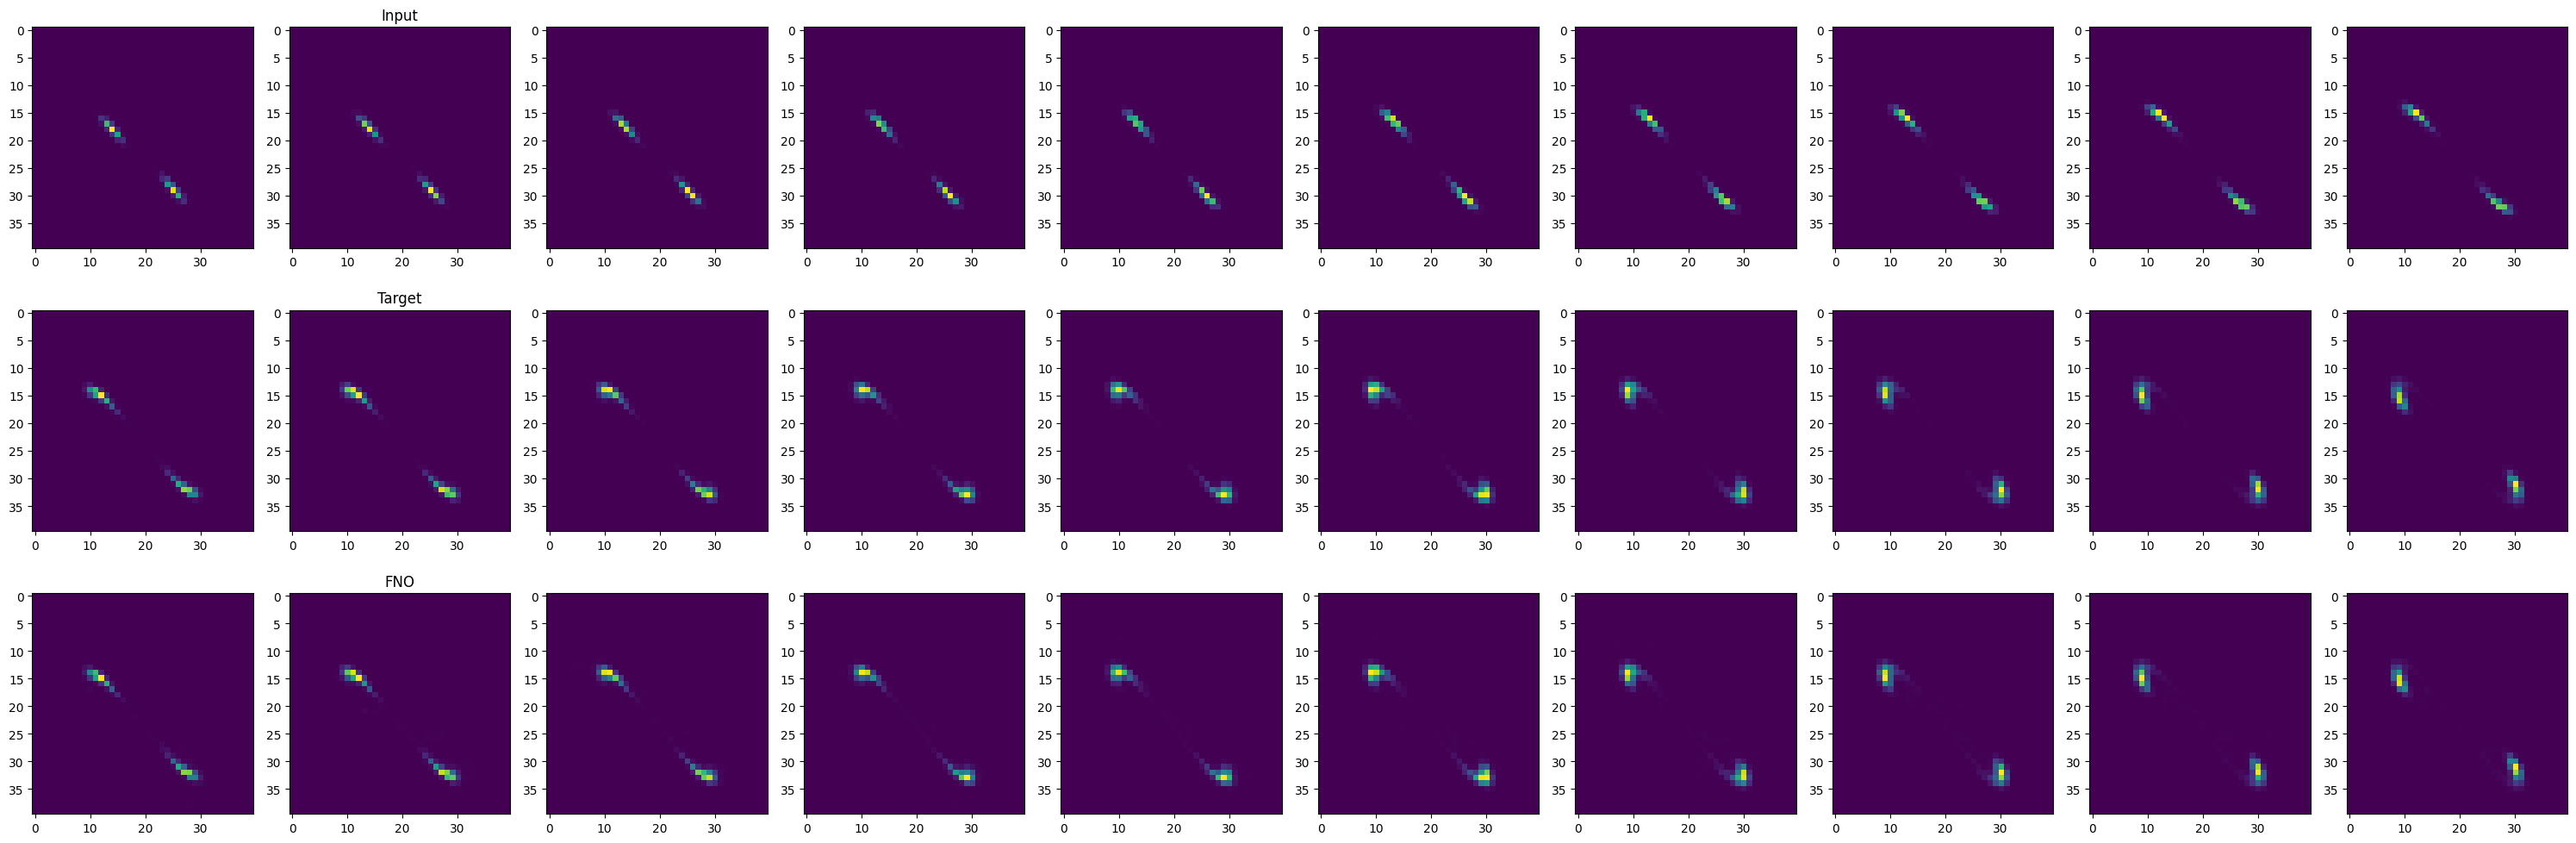

In [81]:
ind = np.random.randint(len(test_ds))

sample = test_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)

fig, ax = plt.subplots(3, a.shape[1], figsize=(a.shape[1]*3,10))


for j in range(a.shape[1]):
    ax[0, j].imshow(a[0, j, ...].cpu())
ax[0, 1].set_title("Input")


for j in range(a.shape[1]):
    ax[1, j].imshow(p[0, j, ...].cpu())
ax[1, 1].set_title("Target")

pred = model(a.unsqueeze(0)).relu()[0].cpu().detach().numpy()

for j in range(a.shape[1]):
    ax[2, j].imshow(pred[0, j, ...])

ax[2, 1].set_title("FNO")

plt.tight_layout()
plt.savefig('test.png')